1.Last name: Liu

2.Date: 1/30/2020

3.Approach: build two deep learning models (with and without 'gender' variable) with h2o 

4.AUC:0.846

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame

from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

## Load data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [3]:
test = pd.read_csv('test.csv')
test.head()
res = test

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.3+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9751 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 703.2+ KB


## Deal with missing values

In [33]:
print('Train missing value:\n\n', train.isnull().sum(),'\n\nTest missing value:\n\n',test.isnull().sum())
print('\n We could find that there are missing values (gender) both in test data and trainning data \nand the outcome is the target value')

print('\nTrain missing gender value rate:', round(269/train.count().values[0] *100, 2), '%'
      '\nTest missing gender value rate:',round( 249/train.count().values[0] *100, 2 ), '%')

Train missing value:

 age                           0
cost_of_ad                    0
device_type                   0
gender                        0
in_initial_launch_location    0
income                        0
n_drivers                     0
n_vehicles                    0
prior_ins_tenure              0
outcome                       0
dtype: int64 

Test missing value:

 age                             0
cost_of_ad                      0
device_type                     0
gender                        249
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
dtype: int64

 We could find that there are missing values (gender) both in test data and trainning data 
and the outcome is the target value

Train missing gender value rate: 2.76 %
Test missing gender value rate: 2.56 %


In [7]:
# drop missing value of train data
train.dropna(axis = 0, how ='any', inplace = True)
# sepreate missing value of test data into test1 and test2( missing gender value rows)
test1 = test.dropna(axis = 0, how = 'any')
test2 = test[test.gender.isnull()]

In [8]:
# check the unique values
for i in train.columns:
    uniques = sorted(train[i].unique())
    print('{0:25s}{1:10d}'.format(i, len(uniques)), uniques[:5])

age                              45 [16, 17, 18, 19, 20]
cost_of_ad                     9716 [0.003170567, 0.003190502, 0.003190587, 0.003196536, 0.003201041]
device_type                       5 ['Android', 'desktop', 'iPhone', 'laptop', 'other']
gender                            2 ['F', 'M']
in_initial_launch_location         2 [0, 1]
income                         9028 [16241, 16375, 16753, 16812, 17081]
n_drivers                         2 [1, 2]
n_vehicles                        3 [1, 2, 3]
prior_ins_tenure                 23 [0, 1, 2, 3, 4]
outcome                           2 [0, 1]


  gender   outcome
0      F  0.058954
1      M  0.142827


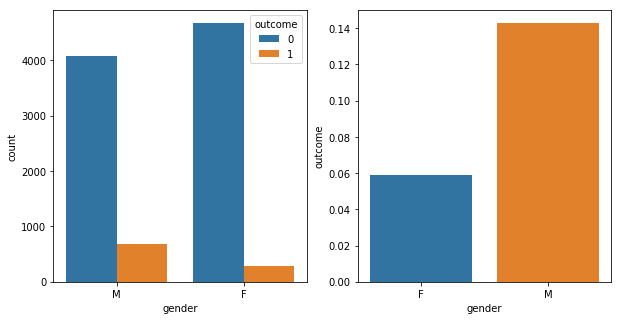

We could easily find that the gender is a very important factor 
the mean outcome of M is almost 3 times of the one of F; 
The training data is unbalanced and we would handle it in model process


In [30]:
gender = train[['gender', 'outcome']].groupby('gender').mean().reset_index()
print(gender)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sns.countplot(x = 'gender', hue = 'outcome', data = train, ax = ax[0])
sns.barplot(x = 'gender', y = 'outcome', data = gender, ax = ax[1])
plt.show()
print('We could easily find that the gender is a very important factor',
      '\nthe mean outcome of M is almost 3 times of the one of F;', 
      '\nThe training data is unbalanced and we would handle it in model process')

##  Build two deep learning model with h2o

### Build the first model with all the features

In [10]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\jiayi\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jiayi\AppData\Local\Temp\tmpkd17wxoo
  JVM stdout: C:\Users\jiayi\AppData\Local\Temp\tmpkd17wxoo\h2o_jiayi_started_from_python.out
  JVM stderr: C:\Users\jiayi\AppData\Local\Temp\tmpkd17wxoo\h2o_jiayi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,7 months and 11 days !!!
H2O cluster name:,H2O_from_python_jiayi_5ehje0
H2O cluster total nodes:,1
H2O cluster free memory:,1.749 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [11]:
data = train
# convert data into h2o, and change relative variable into factors
h2o_df= H2OFrame(data)
h2o_df['outcome']= h2o_df['outcome'].asfactor()
h2o_df['in_initial_launch_location']= h2o_df['in_initial_launch_location'].asfactor()
# h2o_df['gender']= h2o_df['gender'].asfactor()
# h2o_df['n_drivers']= h2o_df['n_drivers'].asfactor()
# h2o_df['n_vehicles']= h2o_df['n_vehicles'].asfactor()
# h2o_df['prior_ins_tenure']= h2o_df['prior_ins_tenure'].asfactor()


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['outcome'].stratified_split(test_frac=0.25, seed=42)

training = h2o_df[strat_split == 'train']
testing = h2o_df[strat_split == 'test']

feature = ['age', 'cost_of_ad', 'device_type', 'gender',
       'in_initial_launch_location', 'income', 'n_drivers', 'n_vehicles',
       'prior_ins_tenure']
target = 'outcome'

In [13]:
# Build model_deep learning
model = H2ODeepLearningEstimator(balance_classes=True, seed = 42)

model.train(x=feature, y=target, training_frame = training)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [14]:
# Make predictions
train_true = training.as_data_frame()['outcome'].values
test_true = testing.as_data_frame()['outcome'].values
train_pred = model.predict(training).as_data_frame()['p1'].values
test_pred = model.predict(testing).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2190
           1       0.53      0.28      0.36       243

   micro avg       0.90      0.90      0.90      2433
   macro avg       0.73      0.62      0.66      2433
weighted avg       0.88      0.90      0.89      2433



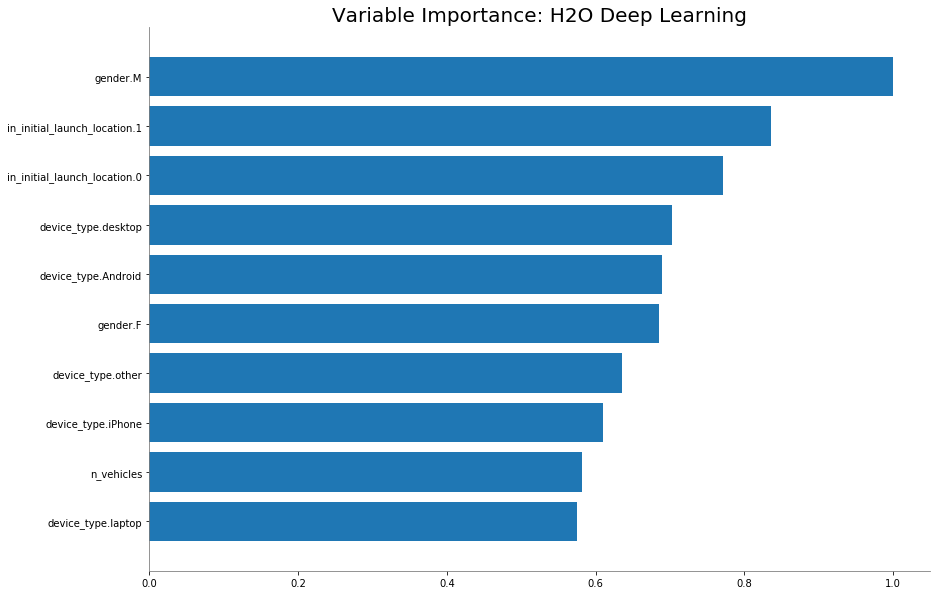

Important variables: gender, in_inital_launch_location, device_type and age


In [15]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.6).astype(int)))
model.varimp_plot()
print('Important variables: gender, in_inital_launch_location, device_type and age')

In [39]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2190
           1       0.49      0.37      0.42       243

   micro avg       0.90      0.90      0.90      2433
   macro avg       0.71      0.66      0.68      2433
weighted avg       0.89      0.90      0.89      2433



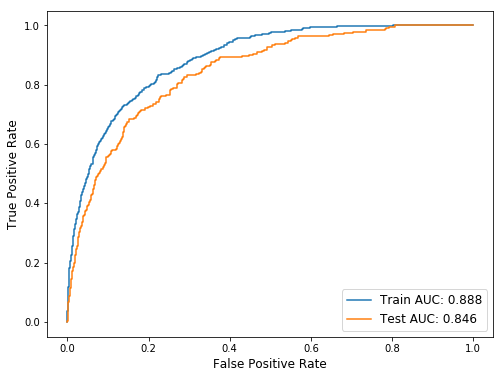

In [17]:
# draw the AUC and ROC
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [18]:
# Use the model to predict the test1 
h2o_test1= H2OFrame(test1)
h2o_test1['in_initial_launch_location']= h2o_test1['in_initial_launch_location'].asfactor()
test1_pred = model.predict(h2o_test1).as_data_frame()['p1'].values
test1_p = list(test1_pred)
outcome = []
for i in test1_p:
    if i > 0.6:
        outcome.append(1)
    else:
        outcome.append(0)
test1['outcome'] = outcome
test1['outcome_prob'] = test1_p
test1.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,outcome_prob
0,34,0.005134,Android,F,1,40376,1,3,7,0,0.003875
1,53,0.005223,desktop,F,1,84511,1,1,11,0,0.122604
2,46,0.004939,laptop,F,0,79322,1,1,4,0,0.168163
3,36,0.004924,Android,F,0,63295,1,2,0,0,0.010565
4,28,0.005146,other,F,1,36170,1,3,3,0,0.000033


###  Model without 'gender' 

In [19]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['outcome'].stratified_split(test_frac=0.25, seed=42)

training = h2o_df[strat_split == 'train']
testing = h2o_df[strat_split == 'test']

feature = ['age', 'cost_of_ad', 'device_type', 
       'in_initial_launch_location', 'income', 'n_drivers', 'n_vehicles',
       'prior_ins_tenure']
target = 'outcome'
# Build model_deep learning without gender
model1 = H2ODeepLearningEstimator(balance_classes=True, seed = 42)

model1.train(x=feature, y=target, training_frame=training)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


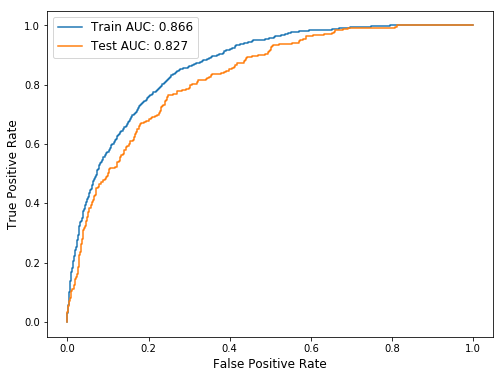

In [20]:
# Make predictions
train_true = training.as_data_frame()['outcome'].values
test_true = testing.as_data_frame()['outcome'].values
train_pred1 = model1.predict(training).as_data_frame()['p1'].values
test_pred1 = model1.predict(testing).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred1)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred1)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [21]:
# # Classification report
# print(classification_report(y_true=test_true, y_pred=(test_pred1 > 0.6).astype(int)))
# model1.varimp_plot()

In [22]:
# Use the model1 to predict the test2 
h2o_test2= H2OFrame(test2)

h2o_test2['in_initial_launch_location']= h2o_test2['in_initial_launch_location'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
test2_pred = model1.predict(h2o_test2).as_data_frame()['p1'].values
test2_pred[:5]

deeplearning prediction progress: |███████████████████████████████████████| 100%


array([0.33938647, 0.01144471, 0.06328547, 0.03008572, 0.13342082])

In [24]:
test2_p = list(test2_pred)
outcome = []
for i in test2_p:
    if i > 0.6:
        outcome.append(1)
    else:
        outcome.append(0)
test2['outcome'] = outcome
test2['outcome_prob'] = test2_p
test2.head()        

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,outcome_prob
69,30,0.003440,desktop,NaN,0,68949,1,2,2,0,0.339386
78,31,0.003442,other,NaN,0,35738,2,2,5,0,0.011445
81,44,0.003662,desktop,NaN,0,71453,1,3,5,0,0.063285
109,22,0.003578,Android,NaN,0,25662,2,3,3,0,0.030086
222,22,0.003304,Android,NaN,1,51174,1,1,2,0,0.133421


In [25]:
test_new = pd.concat([test1, test2])
test_new.info()
test_new.to_csv('test_new.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9976
Data columns (total 11 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9751 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
outcome_prob                  10000 non-null float64
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [28]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_ad1f closed.


In [27]:
test_new.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,outcome_prob
0,34,0.005134,Android,F,1,40376,1,3,7,0,0.003875
1,53,0.005223,desktop,F,1,84511,1,1,11,0,0.122604
2,46,0.004939,laptop,F,0,79322,1,1,4,0,0.168163
3,36,0.004924,Android,F,0,63295,1,2,0,0,0.010565
4,28,0.005146,other,F,1,36170,1,3,3,0,0.000033
